<a href="https://colab.research.google.com/github/shawar8/cifar10_image_classification/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Importing all required libraries

import pandas as pd
import numpy as np
from collections import Counter
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow
import matplotlib.pyplot as plt

In [3]:
### Importing the cifar 10 dataset and splitting it into train and test

from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
### Reshaping the data into a format so as to make it easy to input into the plotting function

y_train = y_train.reshape(1, -1)[0]
y_test = y_test.reshape(1, -1)[0]

In [5]:
### creating a label dictionary for each of the image classes

img_labels = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}
img_labels_rev = {j:i for (i,j) in img_labels.items()}

In [8]:
### Creating a function to plot a certain number of images of a certain class from either the train or test set

def get_image_samples(x_data, y_labels, label, num_images, x_imgs, y_imgs, img_labels):
  num_class_images = x_data[y_labels == [img_labels[label]]].shape[0]
  random_samples = np.random.randint(0,num_class_images,num_images)
  sample_imgs = x_data[y_labels == img_labels[label]][random_samples]
  x_dim = (32* x_imgs) + ((x_imgs - 1) * 2)
  y_dim = (32 *y_imgs) + ((y_imgs - 1) * 2)
  plot_ = np.zeros((x_dim, y_dim, 3))
  counter = 0
  for i in range(0, x_imgs):
    for j in range(0, y_imgs):
      plot_[(i*2)+(i*32): (i*2)+(i*32)+32, (j*2)+(j*32):(j*2)+(j*32)+32,:] = sample_imgs[counter]
      counter += 1
  plt.imshow(plot_/255.)

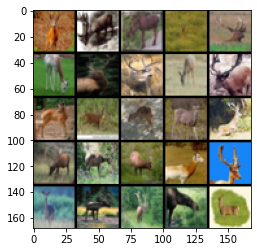

In [9]:
### Plotting 25 random images of deer from test set in a 5x5 grid

get_image_samples(x_test, y_test, 'deer', 25, 5, 5, img_labels)

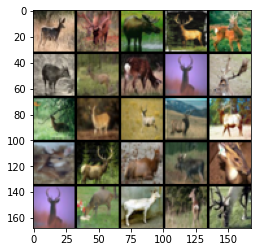

In [10]:
### Plotting 25 random images of deer from training set in a 5x5 grid for comparison with test set

get_image_samples(x_train, y_train, 'deer', 25, 5, 5, img_labels)

In [11]:
### Splitting the test data into a validation set and test set of 5000 images each

x_val, y_val = x_test[:5000], y_test[:5000]
x_test, y_test = x_test[5000:], y_test[5000:]

In [12]:
### Checking to see if the validation set and test set have a good distribution of each class of image

y_val_counter = dict(Counter(y_val))
y_test_counter = dict(Counter(y_test))
y_val_counter = {img_labels_rev[i]:j for i,j in y_val_counter.items()}
y_test_counter = {img_labels_rev[i]:j for i,j in y_test_counter.items()}

print (f'Number of images per Class in validation set -> {y_val_counter}')
print (f'Number of images per Class in test set -> {y_test_counter}')

Number of images per Class in validation set -> {'cat': 497, 'ship': 504, 'airplane': 488, 'frog': 491, 'automobile': 505, 'truck': 513, 'dog': 488, 'horse': 495, 'deer': 507, 'bird': 512}
Number of images per Class in test set -> {'horse': 505, 'frog': 509, 'ship': 496, 'deer': 493, 'dog': 512, 'cat': 503, 'airplane': 512, 'bird': 488, 'automobile': 495, 'truck': 487}


In [13]:
### The keras model requires the labels to be input in a one-hot encoded format 

y_train, y_val, y_test = tensorflow.keras.utils.to_categorical(y_train), tensorflow.keras.utils.to_categorical(y_val), tensorflow.keras.utils.to_categorical(y_test)

In [15]:
### creating the regularizer and optimizer that will go into the model

kernel_regularizer = tensorflow.keras.regularizers.l2(1e-4)
opt = tensorflow.keras.optimizers.RMSprop(learning_rate = 0.001)

In [16]:
###Building the model

### Block 1
model = models.Sequential()
model.add(layers.Conv2D(filters = 192, kernel_size = 3, strides = 1, padding = 'same', input_shape = (32, 32, 3), activation = 'relu', kernel_initializer= 'glorot_normal',
                        kernel_regularizer = kernel_regularizer
                        ))
model.add(layers.Dropout(0.5))

## Block 2
model.add(layers.Conv2D(filters = 96, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer= 'glorot_uniform', activation = 'relu',
                        kernel_regularizer = kernel_regularizer
                        ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

## Block 3
model.add(layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation= 'relu', kernel_initializer= 'glorot_normal',
                        kernel_regularizer = kernel_regularizer
                        ))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())

## Block 4
model.add(layers.Conv2D(filters = 160, kernel_size = 3, strides = 1, padding = 'same', activation= 'relu', kernel_initializer= 'glorot_normal',
                        kernel_regularizer = kernel_regularizer
                        ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

## Block 5
model.add(layers.Conv2D(filters = 224, kernel_size = 3, strides = 1, padding = 'same', activation= 'relu', kernel_initializer= 'glorot_normal',
                        kernel_regularizer = kernel_regularizer
                        ))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())

##Block 6
model.add(layers.Conv2D(filters = 224, kernel_size = 3, strides = 1, padding = 'same', activation= 'relu', kernel_initializer= 'glorot_normal',
                        kernel_regularizer = kernel_regularizer
                        ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

## Fully Connected Layer
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation = 'softmax'))

## Compile
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 192)       5376      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 192)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        165984    
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 96)        384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        1

In [18]:
### Applying the reduceLR on plateau callback to reduce the learning rate when the validation loss doesnt seem to reduce over 5 epochs

callbacks = [tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose= 1)]

In [19]:
### Training the model

history = model.fit(x = x_train, y = y_train, batch_size = 32, epochs = 50, callbacks = callbacks, validation_data= (x_val, y_val))

Epoch 1/50
1563/1563 [==============================] - 92s 59ms/step - loss: 1.9374 - accuracy: 0.3717 - val_loss: 1.6937 - val_accuracy: 0.5206 - lr: 0.0010
Epoch 2/50
1563/1563 [==============================] - 91s 58ms/step - loss: 1.5816 - accuracy: 0.5131 - val_loss: 1.3900 - val_accuracy: 0.6052 - lr: 0.0010
Epoch 3/50
1563/1563 [==============================] - 91s 58ms/step - loss: 1.5043 - accuracy: 0.5618 - val_loss: 1.4615 - val_accuracy: 0.6372 - lr: 0.0010
Epoch 4/50
1563/1563 [==============================] - 91s 58ms/step - loss: 1.4447 - accuracy: 0.5942 - val_loss: 1.8422 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 5/50
1563/1563 [==============================] - 91s 59ms/step - loss: 1.3850 - accuracy: 0.6215 - val_loss: 1.3077 - val_accuracy: 0.6612 - lr: 0.0010
Epoch 6/50
1563/1563 [==============================] - 92s 59ms/step - loss: 1.3326 - accuracy: 0.6426 - val_loss: 1.1631 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 7/50
1563/1563 [========================

In [20]:
### Getting the history of the model
output = history.history

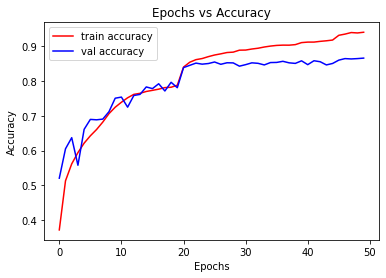

In [21]:
## Plotting accuracy

train_acc = output['accuracy']
val_acc = output['val_accuracy']

plt.plot(range(50), train_acc, color = 'r', label = 'train accuracy')
plt.plot(range(50), val_acc, color = 'b', label = 'val accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()

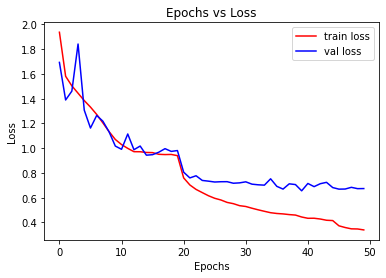

In [22]:
## Plotting loss

train_loss = output['loss']
val_loss = output['val_loss']

plt.plot(range(50), train_loss, color = 'r', label = 'train loss')
plt.plot(range(50), val_loss, color = 'b', label = 'val loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()

In [23]:
### Checking the predictions the model made on the validation set

y_pred = np.array([np.argmax(i) for i in model.predict(x_val)])
y_val_labels = np.array([np.argmax(i) for i in y_val])

In [24]:
### Printing the number of wrong predictions made per class

print ('Number of wrong predictions per Class')
{img_labels_rev[i]: j for i,j in Counter(y_val_labels[y_pred != y_val_labels]).items()}

Number of wrong predictions per Class


{'airplane': 60,
 'automobile': 25,
 'bird': 119,
 'cat': 124,
 'deer': 53,
 'dog': 99,
 'frog': 56,
 'horse': 47,
 'ship': 32,
 'truck': 54}

In [25]:
### Having a look at what wrong predictions were made in the case of cats

wrong_cat_val = x_val[(y_val_labels == 3) & (y_val_labels != y_pred)]
wrong_cat_label = y_val_labels[(y_val_labels == 3) & (y_val_labels != y_pred)]
wrong_cat_pred = y_pred[(y_val_labels == 3) & (y_val_labels != y_pred)]

print ('Wrong predictions made for Cats by class')
{img_labels_rev[i]: j for i,j in Counter(wrong_cat_pred).items()}

Wrong predictions made for Cats by class


{'airplane': 7,
 'bird': 18,
 'deer': 20,
 'dog': 55,
 'frog': 13,
 'horse': 7,
 'ship': 3,
 'truck': 1}

In [26]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose = 0)
print (f'The loss of the model is {test_loss} and accuracy is {np.round(test_accuracy * 100, 2)}%')

The loss of the model is 0.6296612620353699 and accuracy is 87.02%
